Use Optuna to optimize the hyperparameters of the projection head for HAR.

- architecture: N hidden layers (1 to 2), N neurons (4 to 256), dropout (0 to 0.5)
- optimizer: lr, weight decay

In [ ]:
import torch as t
import torch.nn as nn
import torch.nn.functional as F
from torch.utils.data import DataLoader#, #Dataset, 
import torch.optim as optim

#from torch.nn import Module, Sequential, Conv2d, BatchNorm2d, ReLU, MaxPool2d, AvgPool2d, Linear, Dropout, ZeroPad2d, CrossEntropyLoss
#from torch.optim import SGD, Adam, AdamW, lr_scheduler
#from tqdm import tqdm

import optuna
from optuna.trial import TrialState
from optuna.visualization import plot_param_importances, plot_optimization_history
import plotly
from plotly.io import show

from utils_preprocess import *
from utils_traintest import *
from models.ResNet18 import ResNet18

seed = 203345656
torch.manual_seed(seed)

In [81]:
# define the model to optimize
# a FFNN, optimize the number of layers, hidden units, dropout 
def define_model(trial, num_classes):
    n_layers = trial.suggest_int("n_layers", 1, 2)
    layers = []

    in_features = 2560
    for i in range(n_layers):
        out_features = trial.suggest_int("n_units_l{}".format(i), 4, 256)
        layers.append(nn.Linear(in_features, out_features))
        layers.append(nn.ReLU(inplace=True))
        p = trial.suggest_float("dropout_l{}".format(i), 0, 0.5)
        layers.append(nn.Dropout(p))

        in_features = out_features
    layers.append(nn.Linear(in_features, num_classes))

    return nn.Sequential(*layers)

def objective(trial, save_model=False, **kwargs):
    
    num_classes = kwargs['num_classes']
    train_feats_data = kwargs['train_feats']
    val_feats_data = kwargs['val_feats']
    batch_size = kwargs['batch_size']
    device = kwargs['device']
    epochs = kwargs['epochs']
    save_dir = kwargs['save_dir']
    save_name = kwargs['save_name']
    
    # Generate the model
    model = define_model(trial, num_classes).to(device)

    # generate the optimizer
    lr = trial.suggest_float("lr", 1e-5, 1e-1, log=True)
    weight_decay = trial.suggest_float("weight_decay", 1e-4, 1e-1, log=True)
    optimizer = optim.AdamW(model.parameters(), lr=lr, weight_decay=weight_decay)

    train_loader = DataLoader(train_feats_data, batch_size=batch_size, shuffle=True, drop_last=False)
    val_loader = DataLoader(val_feats_data, batch_size=batch_size, shuffle=False, drop_last=False)

    best_val = np.inf
    for epoch in range(epochs):
        #print("Epoch {}".format(epoch))
        model.train()
        for batch in train_loader:
            feats, labels = batch
            feats = feats.to(device)
            labels = labels.to(device)
            labels = labels.squeeze(dim=1)
            preds = model(feats)
            loss = F.cross_entropy(preds, labels)
            optimizer.zero_grad()
            loss.backward()
            optimizer.step()

        model.eval()
        with torch.no_grad():
            vlosses = []
            model.eval()
            for batch in val_loader:
                feats, labels = batch
                feats = feats.to(device)
                labels = labels.to(device)
                labels = labels.squeeze(dim=1)
                preds = model(feats)
                loss = F.cross_entropy(preds, labels)
                vlosses.append(loss.item())

            val_loss = np.mean(vlosses)

        if save_model:
            if val_loss < best_val:
                model_scripted = torch.jit.script(model) 
                model_scripted.save(os.path.join(save_dir, save_name))
                best_val = val_loss

        trial.report(val_loss, epoch)

        # Handle pruning based on the intermediate value.
        if trial.should_prune():
            raise optuna.exceptions.TrialPruned()

    return val_loss

In [ ]:
# call the trained encoder
simclr_model = ResNet18(hidden_dimension=16)
path_model = 'models/ResNet18/My_ResNet18_hd16_bs128.ckpt'
device = 'cuda' if torch.cuda.is_available() else 'cpu'
simclr_model.load_state_dict(torch.load(path_model, map_location=torch.device(device), weights_only=True))

<All keys matched successfully>

#### HAR projection head optimization
NB: Optuna optimizes the hyperparameters, but does not (straightforwardly) save the network models and weights. Thus, once the hyperparameters are chosen, it is necessary to re-train the model to test it.

In [4]:
# prepare the training and validation data
num_classes = 5
dir_init = './doppler_traces/' #Directory of data
subdirs_init = 'S1a,S1b,S1c' #Subdirs for training

dataset_csi_train_class = create_training_set(dir_init=dir_init, subdirs_init=subdirs_init)
dataset_csi_val_class = create_validation_set(dir_init=dir_init, subdirs_init=subdirs_init)

# prepare the features
train_feats = prepare_data_features(simclr_model, dataset_csi_train_class, device=device)
val_feats = prepare_data_features(simclr_model, dataset_csi_val_class, device=device)

100%|██████████| 210/210 [01:33<00:00,  2.26it/s]


In [88]:
batch_size = 64
epochs = 100
save_dir = 'models/ResNet18/My_ResNet18_hd16_bs128'
save_name = 'SimpleClassifierOptimized_HAR.pt'

kwargs = {'num_classes': num_classes,
          'train_feats':train_feats,
          'val_feats': val_feats,
          'device': device,
          'batch_size': batch_size,
          'epochs': epochs,
          'save_dir': save_dir,
          'save_name': save_name}

# run the optimizer
study = optuna.create_study(direction="minimize")
study.optimize(lambda trial: objective(trial, save_model=False, **kwargs), n_trials=200, n_jobs=-1)

pruned_trials = study.get_trials(deepcopy=False, states=[TrialState.PRUNED])
complete_trials = study.get_trials(deepcopy=False, states=[TrialState.COMPLETE])

print("Study statistics: ")
print("  Number of finished trials: ", len(study.trials))
print("  Number of pruned trials: ", len(pruned_trials))
print("  Number of complete trials: ", len(complete_trials))

print("Best trial:")
best_trial = study.best_trial

print("  Value: ", best_trial.value)

print("  Params: ")
for key, value in best_trial.params.items():
    print("    {}: {}".format(key, value))

fig = plot_param_importances(study)
show(fig)

### (RE)TRAIN THE BEST MODEL
objective(best_trial, save_model=True, **kwargs)

[I 2025-01-15 19:22:44,666] A new study created in memory with name: no-name-175a1b23-84fb-49dd-ada2-b7cdb32e8012


Epoch 0
Epoch 1
Epoch 2
Epoch 3
Epoch 4
Epoch 5
Epoch 6
Epoch 7
Epoch 8
Epoch 9


[I 2025-01-15 19:23:25,092] Trial 0 finished with value: 0.6528741044199197 and parameters: {'n_units_l0': 256, 'dropout_l0': 0.0, 'lr': 0.01474729343840819, 'weight_decay': 0.008280680964559136}. Best is trial 0 with value: 0.6528741044199197.


Epoch 0
Epoch 1
Epoch 2
Epoch 3
Epoch 4
Epoch 5
Epoch 6
Epoch 7
Epoch 8
Epoch 9


[I 2025-01-15 19:24:02,442] Trial 1 finished with value: 0.5364990374109391 and parameters: {'n_units_l0': 256, 'dropout_l0': 0.0, 'lr': 2.2255904940562358e-05, 'weight_decay': 0.0006099262666660295}. Best is trial 1 with value: 0.5364990374109391.


Epoch 0
Epoch 1
Epoch 2
Epoch 3
Epoch 4
Epoch 5
Epoch 6
Epoch 7
Epoch 8
Epoch 9


[I 2025-01-15 19:24:39,041] Trial 2 finished with value: 0.7227133529627064 and parameters: {'n_units_l0': 256, 'dropout_l0': 0.0, 'lr': 0.02113049284753265, 'weight_decay': 0.014902912566074112}. Best is trial 1 with value: 0.5364990374109391.


Epoch 0
Epoch 1
Epoch 2
Epoch 3
Epoch 4
Epoch 5
Epoch 6
Epoch 7
Epoch 8
Epoch 9


[I 2025-01-15 19:25:16,403] Trial 3 finished with value: 1.176174545696094 and parameters: {'n_units_l0': 256, 'dropout_l0': 0.0, 'lr': 0.037521210419948464, 'weight_decay': 0.01797758877755618}. Best is trial 1 with value: 0.5364990374109391.


Epoch 0
Epoch 1
Epoch 2
Epoch 3
Epoch 4
Epoch 5
Epoch 6
Epoch 7
Epoch 8
Epoch 9


[I 2025-01-15 19:25:48,253] Trial 4 finished with value: 0.4908310715638306 and parameters: {'n_units_l0': 256, 'dropout_l0': 0.0, 'lr': 0.0015532976177085546, 'weight_decay': 0.00416355106334974}. Best is trial 4 with value: 0.4908310715638306.


Study statistics: 
  Number of finished trials:  5
  Number of pruned trials:  0
  Number of complete trials:  5
Best trial:
  Value:  0.4908310715638306
  Params: 
    n_units_l0: 256
    dropout_l0: 0.0
    lr: 0.0015532976177085546
    weight_decay: 0.00416355106334974


In [ ]:
#### TEST THE BEST MODEL
dir_init = './doppler_traces/' #Directory of data
subdirs_init = 'S1a,S1b,S1c' #Subdirs for training

dataset_csi_test_class, labels_true_test = create_test_set(dir_init=dir_init, subdirs_init=subdirs_init)
test_feats = prepare_data_features(simclr_model, dataset_csi_test_class, device=device)
labels_considered = np.arange(5)

100%|██████████| 205/205 [02:04<00:00,  1.65it/s]


100%|██████████| 103/103 [00:00<00:00, 176.12it/s]


shape of the predicted labels list: torch.Size([6544, 5])
shape of the true labels: torch.Size([6544])
loss: 0.5089306831359863, accuracy: 0.792940080165863


/home/giovanni/Desktop/Deep Learning/project/NNDL HAR project/utils_traintest.py:456: UserWarning:

There are no gridspecs with layoutgrids. Possibly did not call parent GridSpec with the "figure" keyword

/home/giovanni/miniconda3/envs/dlproject/lib/python3.12/site-packages/IPython/core/pylabtools.py:170: UserWarning:

There are no gridspecs with layoutgrids. Possibly did not call parent GridSpec with the "figure" keyword



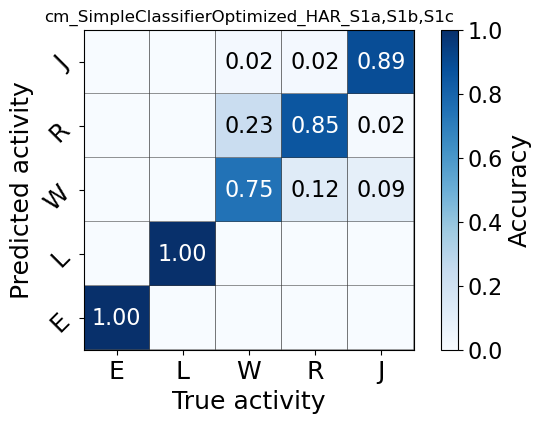

In [90]:
best_model = torch.jit.load(save_dir+save_name)
classifier_model = best_model
device = 'cuda' if torch.cuda.is_available() else 'cpu'
classifier_model.to(device)
classifier_model.eval()
batch_size = 64
loss_fn = torch.nn.CrossEntropyLoss()

with torch.no_grad():
    predictions = []
    true = []

    test_loader = DataLoader(test_feats, batch_size=batch_size, shuffle=False, drop_last=False)

    for batch in tqdm(test_loader):
        feats, labels = batch
        feats = feats.to(device)
        labels = labels.to(device)
        labels = labels.squeeze(dim=1)
        preds = classifier_model(feats)
        predictions.append(preds)
        true.append(labels)

    predictions = torch.cat(predictions, axis=0) # concatenate the predictions for all batches
    true = torch.cat(true, axis=0)
    print("shape of the predicted labels list:", predictions.shape)
    print("shape of the true labels:", true.shape)
    test_loss = loss_fn(predictions, true)
    true = true.detach().cpu()
    labels_pred_list_test = torch.softmax(predictions, dim=1).detach().cpu()
    labels_pred_test = labels_pred_list_test.argmax(dim=1) # restituisce l'indice del valore maggiore
    test_acc = (labels_pred_test == true).float().mean()
    conf_matrix = confusion_matrix(true, labels_pred_test)
    print(f"loss: {test_loss}, accuracy: {test_acc}")

labels_pred_max_merged = merge_predictions(labels_true_test, labels_pred_list_test, labels_pred_test)
conf_matrix_max_merged = confusion_matrix(labels_true_test, labels_pred_max_merged, labels=labels_considered)
activities = np.array(['E','L','W','R','J'])
plt_confusion_matrix(activities.shape[0], conf_matrix_max_merged, lables=activities, title='SimpleClassifierOptimized_HAR_'+str(subdirs_init), save_dir=save_dir, save_name='SimpleClassifierOptimized_HAR')

#### PI projection head optimization

In [4]:
# prepare the training and validation data
num_classes = 3
dir_init = './doppler_traces/' #Directory of data
subdirs_init = 'S1a,S1b,S1c' #Subdirs for training

dataset_PI_train_class = create_training_set(dir_init=dir_init, subdirs_init=subdirs_init, PI=num_classes)
dataset_PI_val_class = create_validation_set(dir_init=dir_init, subdirs_init=subdirs_init, PI=num_classes)

# prepare the features
train_feats_PI = prepare_data_features(simclr_model, dataset_PI_train_class, device=device)
val_feats_PI = prepare_data_features(simclr_model, dataset_PI_val_class, device=device)

100%|██████████| 70/70 [00:26<00:00,  2.61it/s]


In [27]:
batch_size = 64
epochs = 100
save_dir = 'models/ResNet18/My_ResNet18_hd16_bs128'
save_name = 'SimpleClassifierOptimized_PI.pt'

kwargs = {'num_classes': num_classes,
          'train_feats':train_feats_PI,
          'val_feats': val_feats_PI,
          'device': device,
          'batch_size': batch_size,
          'epochs': epochs,
          'save_dir': save_dir,
          'save_name': save_name}

# run the optimizer
study = optuna.create_study(direction="minimize")
study.optimize(lambda trial: objective(trial, save_model=False, **kwargs), n_trials=200, n_jobs=-1)

pruned_trials = study.get_trials(deepcopy=False, states=[TrialState.PRUNED])
complete_trials = study.get_trials(deepcopy=False, states=[TrialState.COMPLETE])

print("Study statistics: ")
print("  Number of finished trials: ", len(study.trials))
print("  Number of pruned trials: ", len(pruned_trials))
print("  Number of complete trials: ", len(complete_trials))

print("Best trial:")
trial = study.best_trial

print("  Value: ", trial.value)

print("  Params: ")
for key, value in trial.params.items():
    print("    {}: {}".format(key, value))

fig = plot_param_importances(study)
show(fig)

### (RE)TRAIN THE BEST MODEL
objective(best_trial, save_model=True, **kwargs)

[I 2025-01-13 15:16:00,295] A new study created in memory with name: no-name-89f54140-65dc-4216-8594-7031ce622554
[I 2025-01-13 15:16:05,567] Trial 7 finished with value: 0.0 and parameters: {'n_layers': 1, 'n_units_l0': 158, 'dropout_l0': 0.0962617721398194, 'lr': 0.01082450055977514, 'weight_decay': 0.01908820960235018}. Best is trial 7 with value: 0.0.
[I 2025-01-13 15:16:05,959] Trial 2 finished with value: 0.0 and parameters: {'n_layers': 1, 'n_units_l0': 254, 'dropout_l0': 0.21939382899486504, 'lr': 0.0007315344018283189, 'weight_decay': 0.011006334237649363}. Best is trial 7 with value: 0.0.
[I 2025-01-13 15:16:06,174] Trial 3 finished with value: 0.2023182477269854 and parameters: {'n_layers': 2, 'n_units_l0': 61, 'dropout_l0': 0.4827216989953583, 'n_units_l1': 48, 'dropout_l1': 0.4954513606474351, 'lr': 1.5032906327758673e-05, 'weight_decay': 0.026505335270966716}. Best is trial 7 with value: 0.0.
[I 2025-01-13 15:16:06,480] Trial 4 finished with value: 0.011173562306378568 an

Study statistics: 
  Number of finished trials:  10
  Number of pruned trials:  4
  Number of complete trials:  6
Best trial:
  Value:  0.0
  Params: 
    n_layers: 1
    n_units_l0: 158
    dropout_l0: 0.0962617721398194
    lr: 0.01082450055977514
    weight_decay: 0.01908820960235018


In [ ]:
#### TEST
dir_init = './doppler_traces/' #Directory of data
subdirs_init = 'S1a,S1b,S1c' #Subdirs for training

dataset_PI_test_class, labels_PI_true_test = create_test_set(dir_init=dir_init, subdirs_init=subdirs_init)
test_feats_PI = prepare_data_features(simclr_model, dataset_PI_test_class, device=device)
labels_considered = np.arange(3)

In [ ]:
best_classifier = torch.jit.load('models/ResNet18/My_ResNet18_hd16_bs128/SimpleClassifierOptimized_PI.pt')

classifier_model = best_classifier
device = 'cuda' if torch.cuda.is_available() else 'cpu'
classifier_model.to(device)
classifier_model.eval()
batch_size = 64
loss_fn = torch.nn.CrossEntropyLoss()

with torch.no_grad():
    predictions = []
    true = []

    test_loader = DataLoader(test_feats_PI, batch_size=batch_size, shuffle=False, drop_last=False)

    for batch in tqdm(test_loader):
        feats, labels = batch
        feats = feats.to(device)
        labels = labels.to(device)
        labels = labels.squeeze(dim=1)
        preds = classifier_model(feats)
        predictions.append(preds)
        true.append(labels)

    predictions = torch.cat(predictions, axis=0) # concatenate the predictions for all batches
    true = torch.cat(true, axis=0)
    print("shape of the predicted labels list:", predictions.shape)
    print("shape of the true labels:", true.shape)
    test_loss = loss_fn(predictions, true)
    true = true.detach().cpu()
    labels_pred_list_test = torch.softmax(predictions, dim=1).detach().cpu()
    labels_pred_test = labels_pred_list_test.argmax(dim=1) # restituisce l'indice del valore maggiore
    test_acc = (labels_pred_test == true).float().mean()
    conf_matrix = confusion_matrix(true, labels_pred_test)
    print(f"loss: {test_loss}, accuracy: {test_acc}")

labels_pred_max_merged = merge_predictions(labels_PI_true_test, labels_pred_list_test, labels_pred_test)
conf_matrix_max_merged = confusion_matrix(labels_PI_true_test, labels_pred_max_merged, labels=labels_considered)
people = np.array(['1','2','3'])
plt_confusion_matrix(activities.shape[0], conf_matrix_max_merged, lables=people, title='SimpleClassifierOptimized_PI_'+str(subdirs_init), save_dir=save_dir, save_name='SimpleClassifierOptimized_PI')

### Ratatuja

In [ ]:
# define the objective function to maximize (or minimize)
# in our case is the accuracy on the validation set
def objective2(trial, **kwargs):
    
    num_classes = kwargs['num_classes']
    train_feats_data = kwargs['train_feats']
    val_feats_data = kwargs['val_feats']
    batch_size = kwargs['batch_size']
    device = kwargs['device']
    epochs = kwargs['epochs']
    
    # Generate the model
    model = define_model(trial, num_classes).to(device)

    # generate the optimizers
    lr = trial.suggest_float("lr", 1e-5, 1e-1, log=True)
    #weight_decay = trial.suggest_float("weight_decay", 1e-4, 1e-1, log=True)
    weight_decay = 1e-3
    optimizer = optim.AdamW(model.parameters(), lr=lr, weight_decay=weight_decay)

    train_loader = DataLoader(train_feats_data, batch_size=batch_size, shuffle=True, drop_last=False)
    val_loader = DataLoader(val_feats_data, batch_size=batch_size, shuffle=False, drop_last=False)

    for epoch in range(epochs):
        print("Epoch {}".format(epoch))
        model.train()
        for batch in train_loader:
            feats, labels = batch
            feats = feats.to(device)
            labels = labels.to(device)
            labels = labels.squeeze(dim=1)
            preds = model(feats)
            loss = F.cross_entropy(preds, labels)
            optimizer.zero_grad()
            loss.backward()
            optimizer.step()

        model.eval()
        with torch.no_grad():
            vaccs = []
            model.eval()
            for batch in val_loader:
                feats, labels = batch
                feats = feats.to(device)
                labels = labels.to(device)
                labels = labels.squeeze(dim=1)
                preds = model(feats)
                acc = (preds.argmax(dim=-1) == labels).float().mean()
                vaccs.append(acc.item())

            val_acc = np.mean(vaccs)
        
        trial.report(val_acc, epoch)

        # Handle pruning based on the intermediate value.
        if trial.should_prune():
            raise optuna.exceptions.TrialPruned()

    return val_acc